In [31]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from scipy.stats import zscore

In [32]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [33]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [ ]:
def factor(df, lookback=120):
    """
    ‰ºòÂåñÁöÑÁªºÂêàÂõ†Â≠êËÆæËÆ°Ôºö
    1. È≥ÑÈ±ºÁ∫øÊñπÂêëÂº∫Â∫¶ÔºöÈ≥ÑÈ±ºÁ∫øÂ§öÂ§¥ÊéíÂàóÁöÑÂº∫Â∫¶ÔºàÊ†áÂáÜÂåñÔºâ
    2. AOÂä®ÈáèÔºöAOÊåáÊ†áÁöÑÁü≠ÊúüÂèòÂåñÁéá
    3. ÂàÜÂΩ¢Á™ÅÁ†¥Ê¶ÇÁéáÔºöÂü∫‰∫éË∑ùÁ¶ªÂàÜÂΩ¢ÁÇπÁöÑ‰ΩçÁΩÆËÆ°ÁÆóÁ™ÅÁ†¥Ê¶ÇÁéá
    4. MACDÂäøËÉΩÔºöMACDÊü±Áä∂ÂõæÂº∫Â∫¶ÁªìÂêà‰ΩçÁΩÆÊùÉÈáç
    5. Êàê‰∫§ÈáèÁ°ÆËÆ§ÔºöÁ™ÅÁ†¥Êó∂ÁöÑÊàê‰∫§ÈáèÈ™åËØÅ
    
    ÊúÄÁªàÂõ†Â≠ê = (È≥ÑÈ±ºÁ∫øÊñπÂêë * AOÂä®Èáè * ÂàÜÂΩ¢Ê¶ÇÁéá) + MACDÂäøËÉΩ + Êàê‰∫§ÈáèÁ°ÆËÆ§
    
    ÊâÄÊúâÁªÑ‰ª∂ÈÉΩÁªèËøáÊ†áÂáÜÂåñÂ§ÑÁêÜÔºåÁ°Æ‰øùÂèØÊØîÊÄß
    """
    # 1. È≥ÑÈ±ºÁ∫øÊñπÂêëÂº∫Â∫¶ ====================================
    median_price = (df['high'] + df['low']) / 2
    lip = median_price.rolling(window=5).mean().shift(3)
    teeth = median_price.rolling(window=8).mean().shift(5)
    jaw = median_price.rolling(window=13).mean().shift(8)
    
    # ËÆ°ÁÆóÈ≥ÑÈ±ºÁ∫øÊéíÂàóÂº∫Â∫¶ÔºàÂ§öÂ§¥‰∏∫Ê≠£ÔºåÁ©∫Â§¥‰∏∫Ë¥üÔºâ
    alligator_direction = np.sign(lip - jaw) * ((lip - teeth).abs() + (teeth - jaw).abs())
    
    # 2. AOÂä®Èáè ==========================================
    sma5 = median_price.rolling(window=5).mean()
    sma34 = median_price.rolling(window=34).mean()
    ao = sma5 - sma34
    
    # AOÁöÑ3ÊúüÂèòÂåñÁéáÔºàÂä®ÈáèÔºâ
    ao_momentum = ao.pct_change(3).replace([np.inf, -np.inf], 0).fillna(0)
    
    # 3. ÂàÜÂΩ¢Á™ÅÁ†¥Ê¶ÇÁéá =====================================
    high = df['high']
    low = df['low']
    close = df['close']
    
    # ËØÜÂà´‰∏äÂàÜÂΩ¢
    up_fractal = (
        (high.shift(2) > high.shift(4)) & 
        (high.shift(2) > high.shift(3)) & 
        (high.shift(2) > high.shift(1)) & 
        (high.shift(2) > high)
    )

    # ËØÜÂà´‰∏ãÂàÜÂΩ¢
    down_fractal = (
        (low.shift(2) < low.shift(4)) & 
        (low.shift(2) < low.shift(3)) & 
        (low.shift(2) < low.shift(1)) & 
        (low.shift(2) < low)
    )

    # Ëé∑ÂèñÊúÄËøëÁöÑÂàÜÂΩ¢ÁÇπ
    last_up_fractal_high = high.where(up_fractal).ffill()
    last_down_fractal_low = low.where(down_fractal).ffill()
    
    # ËÆ°ÁÆóË∑ùÁ¶ªÂàÜÂΩ¢ÁÇπÁöÑÁõ∏ÂØπ‰ΩçÁΩÆ
    dist_to_up_fractal = (close - last_up_fractal_high) / (high - low).rolling(10).mean().replace(0, 1e-5)
    dist_to_down_fractal = (last_down_fractal_low - close) / (high - low).rolling(10).mean().replace(0, 1e-5)
    
    # Á™ÅÁ†¥Ê¶ÇÁéáËÆ°ÁÆóÔºàSigmoidÂáΩÊï∞Ôºâ
    fractal_prob = 1 / (1 + np.exp(-5 * dist_to_up_fractal)) - 1 / (1 + np.exp(-5 * dist_to_down_fractal))
    
    # 4. MACDÂäøËÉΩ ========================================
    close_price = df['close']
    ema12 = close_price.ewm(span=12, adjust=False).mean()
    ema26 = close_price.ewm(span=26, adjust=False).mean()
    dif = ema12 - ema26
    dea = dif.ewm(span=9, adjust=False).mean()
    macd_hist = (dif - dea) * 2
    
    # MACD‰ΩçÁΩÆÊùÉÈáçÔºàÈõ∂ËΩ¥ÈôÑËøëÁªô‰∫àÊõ¥È´òÊùÉÈáçÔºâ
    zero_line_dist = dif.abs()
    position_weight = 1.5 * np.exp(-zero_line_dist / (zero_line_dist.rolling(50).mean().replace(0, 1e-5)))
    
    macd_power = macd_hist * position_weight
    
    # 5. Êàê‰∫§ÈáèÁ°ÆËÆ§ =======================================
    volume = df['volume']
    volume_ma = volume.rolling(20).mean()
    volume_confirm = np.log(volume / volume_ma.replace(0, 1e-5))
    
    # ÁªÑÂêàÊâÄÊúâÂõ†Â≠ê ========================================
    # Ê†áÂáÜÂåñÂêÑÁªÑ‰ª∂Ôºà‰ΩøÁî®z-scoreÔºâ
    components = pd.DataFrame({
        'alligator': alligator_direction,
        'ao_momentum': ao_momentum,
        'fractal_prob': fractal_prob,
        'macd_power': macd_power,
        'volume_confirm': volume_confirm
    })
    
    # ‰ΩøÁî®ÊªöÂä®z-scoreÊ†áÂáÜÂåñ
    z_components = components.apply(lambda x: zscore(x, nan_policy='omit'))
    z_components = z_components.fillna(0)
    
    # ÊúÄÁªàÂõ†Â≠êÁªÑÂêàÔºàÊ†∏ÂøÉÂõ†Â≠êÁõ∏‰πòÔºåËæÖÂä©Âõ†Â≠êÁõ∏Âä†Ôºâ
    core_factor = (z_components['alligator'] * 
                   z_components['ao_momentum'] * 
                   z_components['fractal_prob'])
    
    composite_factor = core_factor + z_components['macd_power'] + z_components['volume_confirm']
    
    # Â∫îÁî®Âπ≥ÊªëÊª§Ê≥¢
    composite_factor = -composite_factor.ewm(span=5).mean()

    # ÂØπÂõ†Â≠êÂÄºÊúÄÂ∞èÁöÑ0.3%ËÆæ‰∏∫0
    top_threshold = composite_factor.quantile(0.003)
    composite_factor[composite_factor <= top_threshold] = 0
    
    return composite_factor

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.010836
   Rank_IC (Spearman): 0.019577
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 1.121341
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 132206
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------


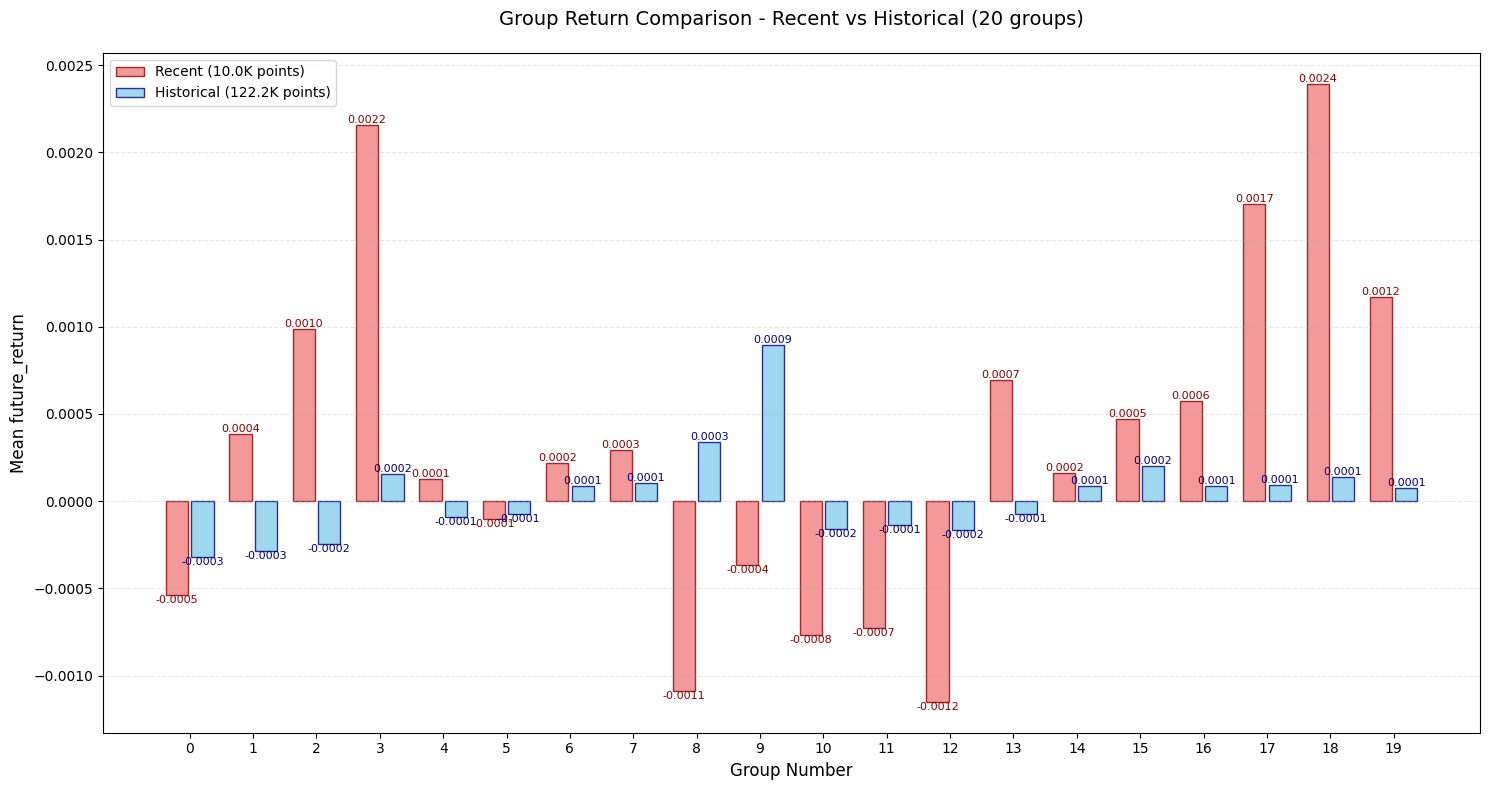

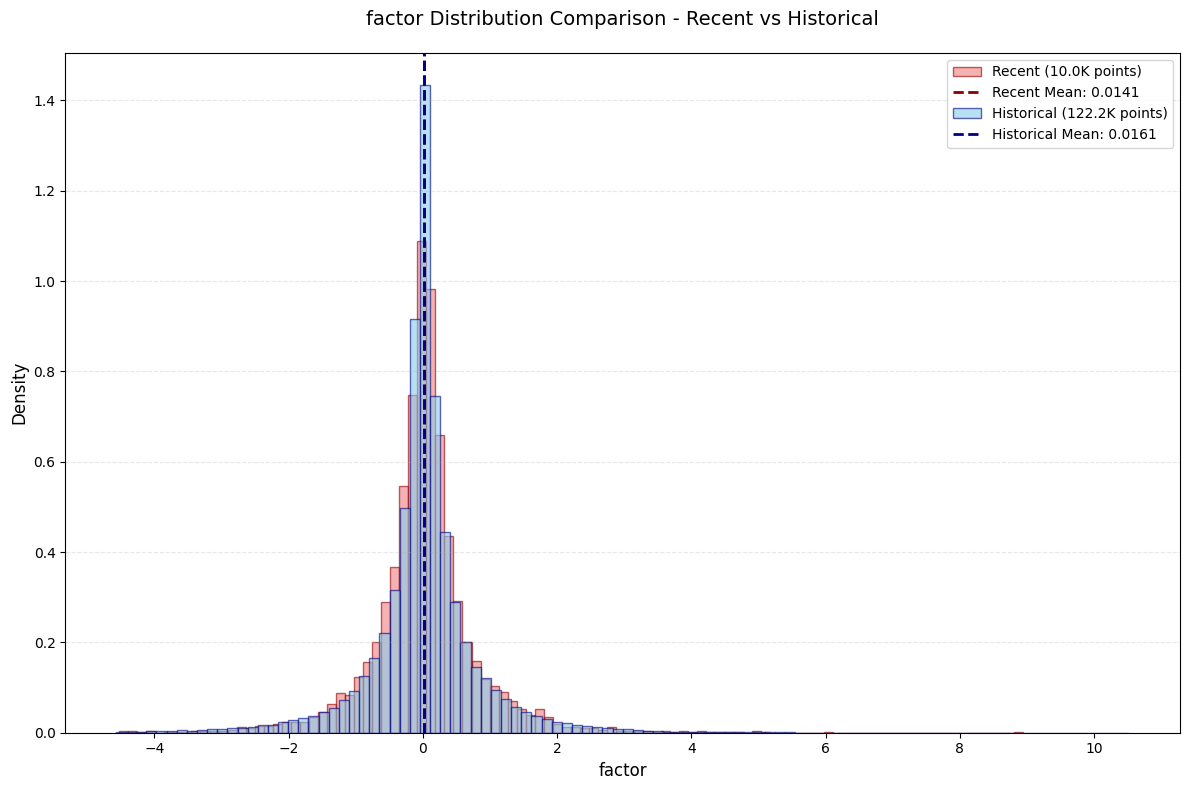

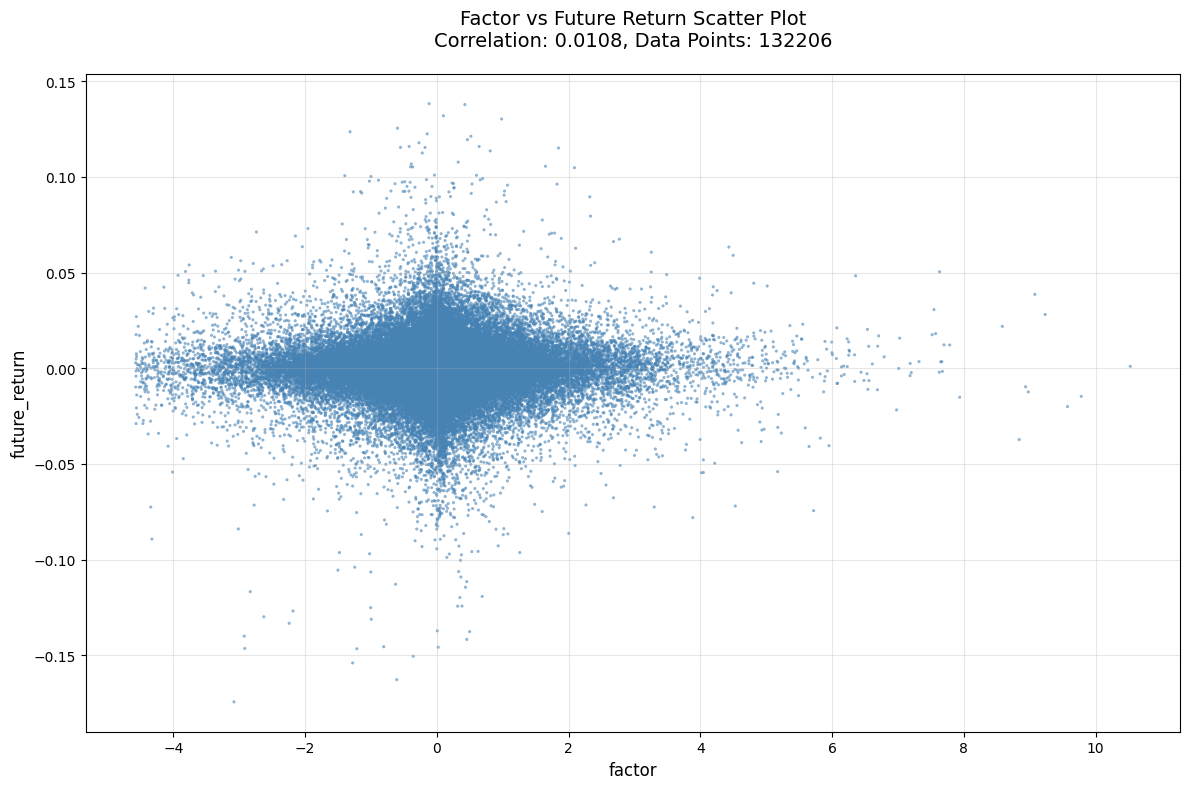

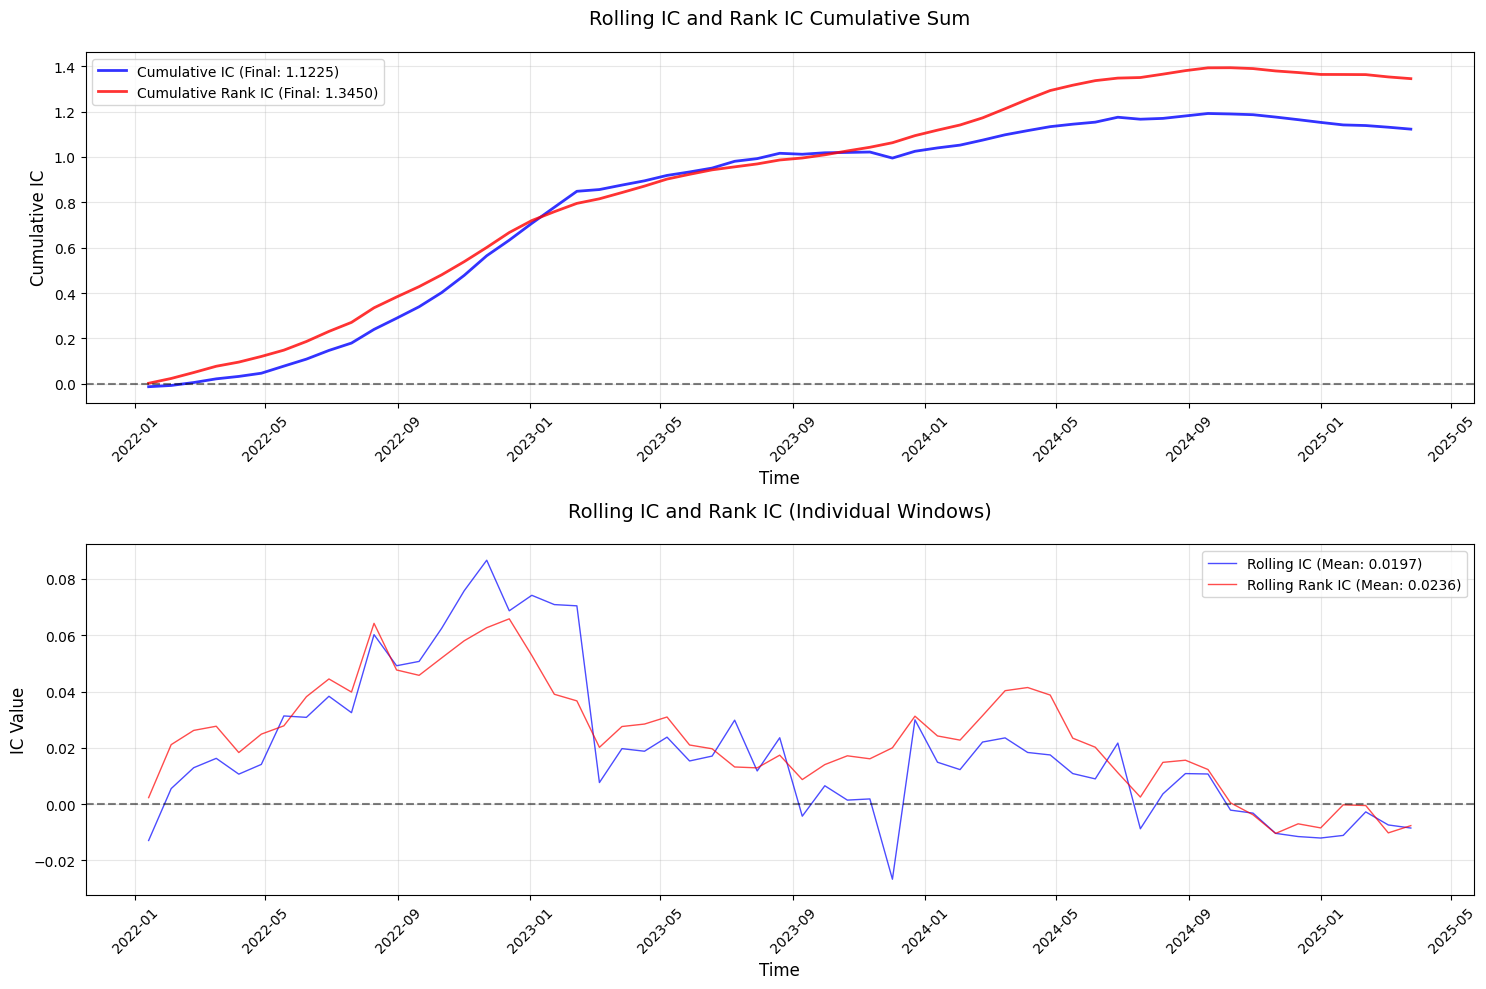

‚úÖ Â∑≤ÊòæÁ§∫ 4 ‰∏™ÂõæÁâá
----------------------------------------


In [35]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [36]:
from tabulate import tabulate

def display_factor_evaluation(result):
    # 1. Âü∫Á°ÄÁªüËÆ°ÊåáÊ†á
    basic_metrics = [
        ["‰ø°ÊÅØÁ≥ªÊï∞(IC)", result['correlation_analysis']['IC']],
        ["Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC)", result['correlation_analysis']['Rank_IC']],
        ["‰ø°ÊÅØÊØîÁéá(IR)", result['information_ratio']['IR']],
        ["ÂàÜÁªÑÊï∞Èáè", result['information_ratio']['n_groups']],
        ["Êï∞ÊçÆÁÇπÊï∞", f"{result['factor_return_scatter']['data_points']:,}"],
        ["ÂºÇÂ∏∏ÂÄº(>3œÉ)", f"{result['factor_distribution']['outlier_analysis']['>3std']*100:.2f}%"],
        ["ÂºÇÂ∏∏ÂÄº(>5œÉ)", f"{result['factor_distribution']['outlier_analysis']['>5std']*100:.2f}%"]
    ]
    
    # 2. ÂàÜÁªÑÂàÜÊûê
    group_stats = result['group_analysis']['group_stats']
    group_table = []
    for idx, row in group_stats.iterrows():
        group_table.append([
            idx,
            f"{row['val_min']:.4f}",
            f"{row['val_max']:.4f}",
            f"{row['val_mean']:.4f}",
            f"{row['return_mean']:.6f}",
            f"{row['return_std']:.4f}",
            row['count']
        ])
    
    # 3. Âõ†Â≠êÂàÜÂ∏ÉÊèèËø∞
    dist_stats = result['factor_distribution']['descriptive_stats']
    distribution_metrics = [
        ["ÂùáÂÄº", f"{dist_stats['mean']:.4f}"],
        ["Ê†áÂáÜÂ∑Æ", f"{dist_stats['std']:.4f}"],
        ["ÊúÄÂ∞èÂÄº", f"{dist_stats['min']:.4f}"],
        ["1%ÂàÜ‰ΩçÊï∞", f"{dist_stats['1%']:.4f}"],
        ["5%ÂàÜ‰ΩçÊï∞", f"{dist_stats['5%']:.4f}"],
        ["25%ÂàÜ‰ΩçÊï∞", f"{dist_stats['25%']:.4f}"],
        ["‰∏≠‰ΩçÊï∞", f"{dist_stats['50%']:.4f}"],
        ["75%ÂàÜ‰ΩçÊï∞", f"{dist_stats['75%']:.4f}"],
        ["95%ÂàÜ‰ΩçÊï∞", f"{dist_stats['95%']:.4f}"],
        ["99%ÂàÜ‰ΩçÊï∞", f"{dist_stats['99%']:.4f}"],
        ["ÊúÄÂ§ßÂÄº", f"{dist_stats['max']:.4f}"]
    ]
    
    # 4. ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß
    group_correlations = []
    for i, corr in enumerate(result['information_ratio']['group_correlations']):
        group_correlations.append([f"ÁªÑ {i+1}", f"{corr:.6f}"])
    
    # 5. ÊªöÂä®ICÂàÜÊûê - ÂÆåÊï¥Â±ïÁ§∫
    rolling_ic = result['rolling_ic_analysis']['rolling_ic']
    rolling_rank_ic = result['rolling_ic_analysis']['rolling_rank_ic']
    window_centers = result['rolling_ic_analysis']['window_centers']
    cumsum_ic = result['rolling_ic_analysis']['cumsum_ic']
    cumsum_rank_ic = result['rolling_ic_analysis']['cumsum_rank_ic']
    
    # ÂàõÂª∫ÊªöÂä®ICÊï∞ÊçÆË°®Ê†º
    rolling_table = []
    for i in range(len(rolling_ic)):
        rolling_table.append([
            window_centers[i].strftime('%Y-%m-%d %H:%M:%S'),
            f"{rolling_ic[i]:.6f}",
            f"{rolling_rank_ic[i]:.6f}",
            f"{cumsum_ic[i]:.6f}",
            f"{cumsum_rank_ic[i]:.6f}"
        ])
    
    # ÊªöÂä®ICÊ±áÊÄªÁªüËÆ°
    rolling_metrics = [
        ["ÊªöÂä®ICÂùáÂÄº", f"{pd.Series(rolling_ic).mean():.6f}"],
        ["ÊªöÂä®ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_ic).std():.6f}"],
        ["ÊªöÂä®Rank ICÂùáÂÄº", f"{pd.Series(rolling_rank_ic).mean():.6f}"],
        ["ÊªöÂä®Rank ICÊ†áÂáÜÂ∑Æ", f"{pd.Series(rolling_rank_ic).std():.6f}"],
        ["Á¥ØÁßØICÁªàÂÄº", f"{cumsum_ic[-1]:.6f}"],
        ["Á¥ØÁßØRank ICÁªàÂÄº", f"{cumsum_rank_ic[-1]:.6f}"],
        ["ÂàùÂßãÁ™óÂè£Â§ßÂ∞è", result['rolling_ic_analysis']['initial_window']],
        ["ÊªöÂä®Ê≠•Èïø", result['rolling_ic_analysis']['rolling_step']]
    ]
    
    # 6. Êó∂Èó¥Á™óÂè£ÁªüËÆ°
    window_stats = []
    window_data = result['factor_distribution']['window_stats'][10]
    
    # Ê≠£Á°ÆÂ§ÑÁêÜÊó∂Èó¥Á™óÂè£ÁªüËÆ°Êï∞ÊçÆ
    if isinstance(window_data['stats'], pd.DataFrame):
        # Â¶ÇÊûúÊòØDataFrameÁªìÊûÑ
        for idx, row in window_data['stats'].iterrows():
            window_stats.append([
                idx,
                f"{row['mean']:.4f}",
                f"{row['std']:.4f}",
                f"{row['skew']:.4f}",
                f"{row['lambda']:.4f}",
                row['count']
            ])
    else:
        # Â¶ÇÊûúÊòØÂ≠óÂÖ∏ÁªìÊûÑ
        for time_range, stats in window_data['stats'].items():
            window_stats.append([
                time_range,
                f"{stats['mean']:.4f}",
                f"{stats['std']:.4f}",
                f"{stats['skew']:.4f}",
                f"{stats['lambda']:.4f}",
                stats['count']
            ])
    
    # # 7. Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú
    # stationarity = result['stationarity_test']
    # stationarity_metrics = [
    #     ["ADFÁªüËÆ°Èáè", stationarity['adf_statistic']],
    #     ["PÂÄº", stationarity['p_value']],
    #     ["1%‰∏¥ÁïåÂÄº", stationarity['critical_values']['1%']],
    #     ["5%‰∏¥ÁïåÂÄº", stationarity['critical_values']['5%']],
    #     ["10%‰∏¥ÁïåÂÄº", stationarity['critical_values']['10%']],
    #     ["ÊòØÂê¶Âπ≥Á®≥", stationarity['is_stationary']],
    #     #["ÊòæËëóÊÄßÊ∞¥Âπ≥", stationarity['alpha']]
    # ]
    
    # ÊâìÂç∞ÊâÄÊúâÁªìÊûú
    print("="*80)
    print("Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á".center(80))
    print("="*80)
    print(tabulate(basic_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    # print("\n" + "="*80)
    # print("Âπ≥Á®≥ÊÄßÊµãËØïÁªìÊûú".center(80))
    # print("="*80)
    # print(tabulate(stationarity_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÂàÜÊûêÁªìÊûú".center(80))
    print("="*80)
    print(tabulate(group_table, headers=["ÂàÜÁªÑ", "ÊúÄÂ∞èÂÄº", "ÊúÄÂ§ßÂÄº", "Âπ≥ÂùáÂÄº", "Êî∂ÁõäÂùáÂÄº", "Êî∂ÁõäÊ†áÂáÜÂ∑Æ", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Âõ†Â≠êÂàÜÂ∏ÉÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(distribution_metrics, headers=["ÁªüËÆ°Èáè", "ÂÄº"], tablefmt="grid", floatfmt=".4f"))
    
    print("\n" + "="*80)
    print("ÂàÜÁªÑÁõ∏ÂÖ≥ÊÄß".center(80))
    print("="*80)
    print(tabulate(group_correlations, headers=["ÂàÜÁªÑ", "Áõ∏ÂÖ≥ÊÄß"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICÂàÜÊûêÊ±áÊÄª".center(80))
    print("="*80)
    print(tabulate(rolling_metrics, headers=["ÊåáÊ†á", "ÂÄº"], tablefmt="grid", floatfmt=".6f"))
    
    print("\n" + "="*80)
    print("ÊªöÂä®ICËØ¶ÁªÜÊï∞ÊçÆ".center(80))
    print("="*80)
    print(tabulate(rolling_table, headers=["Á™óÂè£‰∏≠ÂøÉ", "ÊªöÂä®IC", "ÊªöÂä®Rank IC", "Á¥ØÁßØIC", "Á¥ØÁßØRank IC"], tablefmt="grid"))
    
    print("\n" + "="*80)
    print("Êó∂Èó¥Á™óÂè£ÁªüËÆ°".center(80))
    print("="*80)
    print(tabulate(window_stats, headers=["Êó∂Èó¥Á™óÂè£", "ÂùáÂÄº", "Ê†áÂáÜÂ∑Æ", "ÂÅèÂ∫¶", "Lambda", "Ê†∑Êú¨Êï∞"], tablefmt="grid"))
    print(f"Êó∂Èó¥ËåÉÂõ¥: {window_data['time_ranges']}")

# Ë∞ÉÁî®Â±ïÁ§∫ÂáΩÊï∞
display_factor_evaluation(result)

                                    Âõ†Â≠êËØÑ‰º∞Ê†∏ÂøÉÊåáÊ†á                                    
+---------------------+---------------------+
| ÊåáÊ†á                | ÂÄº                  |
+=====================+=====================+
| ‰ø°ÊÅØÁ≥ªÊï∞(IC)        | 0.01083584217223755 |
+---------------------+---------------------+
| Áß©Áõ∏ÂÖ≥Á≥ªÊï∞(Rank IC) | 0.01957668682992041 |
+---------------------+---------------------+
| ‰ø°ÊÅØÊØîÁéá(IR)        | 1.121341199607896   |
+---------------------+---------------------+
| ÂàÜÁªÑÊï∞Èáè            | 10                  |
+---------------------+---------------------+
| Êï∞ÊçÆÁÇπÊï∞            | 132,206             |
+---------------------+---------------------+
| ÂºÇÂ∏∏ÂÄº(>3œÉ)         | 2.32%               |
+---------------------+---------------------+
| ÂºÇÂ∏∏ÂÄº(>5œÉ)         | 0.31%               |
+---------------------+---------------------+

                                     ÂàÜÁªÑÂàÜÊûêÁªìÊûú                                 